In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [14]:
# 격자 환경 설정
class GridEnvironment:
    def __init__(self, n):
        self.n = n
        self.goal = (0, 0)
        self.max_steps = 2 * n
        self.reset()

    def reset(self):
        self.agent_pos = (np.random.randint(0, self.n), np.random.randint(0, self.n))
        self.steps = 0

    def step(self, action):
        self.steps += 1
        if action == 0:  # Up
            self.agent_pos = (max(0, self.agent_pos[0] - 1), self.agent_pos[1])
        elif action == 1:  # Down
            self.agent_pos = (min(self.n - 1, self.agent_pos[0] + 1), self.agent_pos[1])
        elif action == 2:  # Left
            self.agent_pos = (self.agent_pos[0], max(0, self.agent_pos[1] - 1))
        elif action == 3:  # Right
            self.agent_pos = (self.agent_pos[0], min(self.n - 1, self.agent_pos[1] + 1))

        if self.agent_pos == self.goal:
            reward = 1.0
            done = True
        else:
            reward = -0.1  # Penalty for each non-goal step
            done = self.steps >= self.max_steps

        return np.array(self.agent_pos), reward, done

In [15]:
# 정책 신경망
class PolicyNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return self.softmax(x)

In [16]:
# REINFORCE 알고리즘
def reinforce(env, policy_net, optimizer, num_episodes=1000):
    episode_rewards = []

    for episode in range(num_episodes):
        episode_reward = 0
        log_probs = []
        rewards = []

        state = torch.FloatTensor([env.agent_pos[0], env.agent_pos[1]])

        while True:
            action_probs = policy_net(state)
            action = torch.multinomial(action_probs, 1).item()
            log_probs.append(torch.log(action_probs[action]))

            next_state, reward, done = env.step(action)
            rewards.append(reward)
            episode_reward += reward

            if done:
                break

            state = torch.FloatTensor([next_state[0], next_state[1]])

        episode_rewards.append(episode_reward)

        # 정책 업데이트
        returns = []
        G = 0
        for r in rewards[::-1]:
            G = r + 0.9 * G
            returns.insert(0, G)

        policy_loss = []
        for log_prob, G in zip(log_probs, returns):
            policy_loss.append(-log_prob * G)
        policy_loss = torch.stack(policy_loss).sum()

        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        env.reset()

    return episode_rewards

In [17]:
# 시각화 함수
def plot_rewards(episode_rewards):
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('REINFORCE Algorithm')
    plt.show()

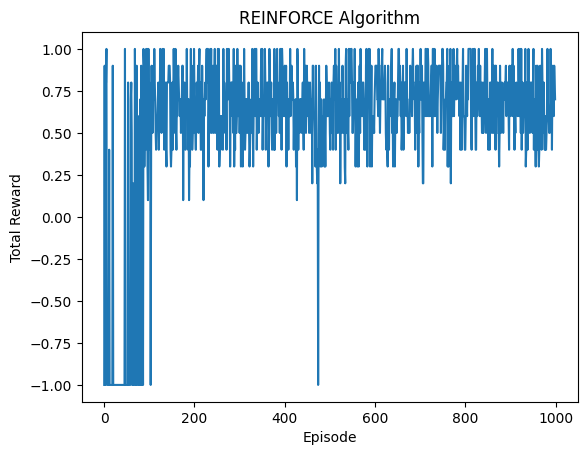

In [18]:
# 주어진 조건에 맞게 초기화
n = 5
env = GridEnvironment(n)
input_size = 2
hidden_size = 32
output_size = 4
policy_net = PolicyNetwork(input_size, hidden_size, output_size)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

# REINFORCE 알고리즘 실행
episode_rewards = reinforce(env, policy_net, optimizer, num_episodes=1000)

# 시각화
plot_rewards(episode_rewards)

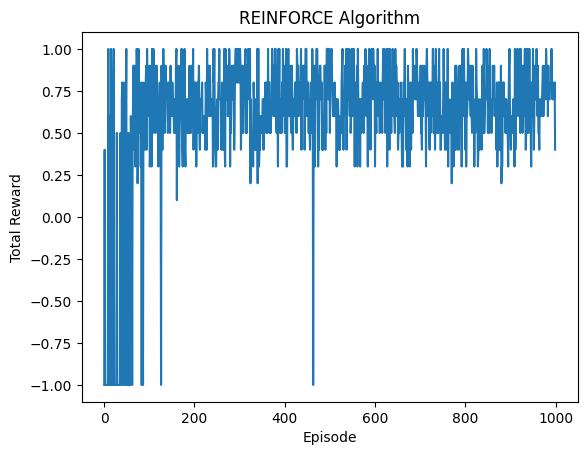

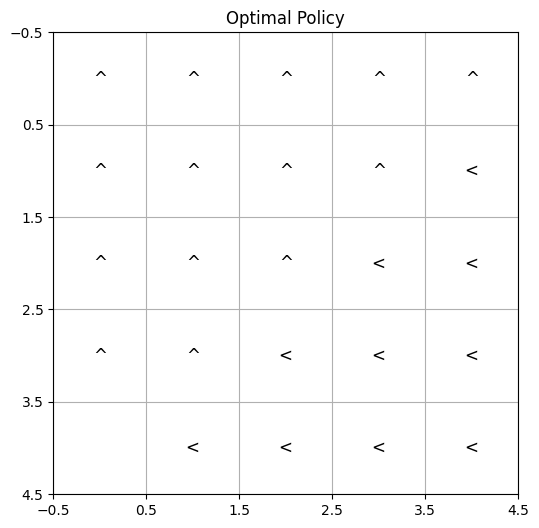

In [19]:
# 최적의 정책을 결정하는 함수
def optimal_policy(env, policy_net):
    optimal_actions = np.zeros((env.n, env.n), dtype=int)
    for i in range(env.n):
        for j in range(env.n):
            state = torch.FloatTensor([i, j])
            action_probs = policy_net(state)
            optimal_actions[i, j] = torch.argmax(action_probs).item()
    return optimal_actions

# 최적의 경로를 시각화하는 함수
def plot_optimal_path(optimal_actions, n):
    actions_map = {0: '^', 1: 'v', 2: '<', 3: '>'}
    plt.figure(figsize=(6, 6))
    for i in range(n):
        for j in range(n):
            if (i, j) != (0, 0):
                plt.text(j, n-1-i, actions_map[optimal_actions[i, j]], ha='center', va='center', fontsize=12)
    plt.xlim(-0.5, n-0.5)
    plt.ylim(-0.5, n-0.5)
    plt.xticks(np.arange(-0.5, n, 1))
    plt.yticks(np.arange(-0.5, n, 1))
    plt.grid(True)
    plt.gca().invert_yaxis()
    plt.title('Optimal Policy')
    plt.show()

# 주어진 조건에 맞게 초기화
n = 5
env = GridEnvironment(n)
input_size = 2
hidden_size = 32
output_size = 4
policy_net = PolicyNetwork(input_size, hidden_size, output_size)
optimizer = optim.Adam(policy_net.parameters(), lr=0.01)

# REINFORCE 알고리즘 실행
episode_rewards = reinforce(env, policy_net, optimizer, num_episodes=1000)

# 최적의 정책 계산
optimal_actions = optimal_policy(env, policy_net)

# 시각화
plot_rewards(episode_rewards)
plot_optimal_path(optimal_actions, n)
